In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [ ]:
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
# Normalize pixels to [0, 1]
X = X / 255.0

In [3]:
x_real = X[:5000].reshape(-1, 28, 28, 1)

In [4]:
nD_input = x_real.shape[1]
nD_hidden = 128
nD_output = 1
nG_input = 50
nG_hidden = 128
nG_output = nD_input

In [5]:
# Build a discriminator model
def Discriminator():
    D_in = Input(batch_shape = (None, 28, 28, 1))
    dh = Conv2D(16, 5, strides=1, activation='leaky_relu', padding='same')(D_in)
    dh = Conv2D(32, 5, strides=2, activation='leaky_relu', padding='same')(dh)
    dh = Conv2D(64, 5, strides=2, activation='leaky_relu', padding='same')(dh)
    dh = Flatten()(dh)
    D_out = Dense(1, activation='sigmoid')(dh)
    return Model(D_in, D_out)

In [6]:
# Build a generator model
def Generator():
    G_in = Input(batch_shape=(None, nG_input))
    gh = Dense(7 * 7 * 32)(G_in)
    gh = Reshape((7, 7, 32))(gh)
    gh = Conv2DTranspose(32, 5, strides=2,padding='same')(gh)
    gh = BatchNormalization()(gh)
    gh = Activation('relu')(gh)
    gh = Conv2DTranspose(16, 5, strides=1,padding='same')(gh)
    gh = BatchNormalization()(gh)
    gh = Activation('relu')(gh)
    gh = Conv2DTranspose(1, 5, strides=2,padding='same')(gh)
    G_out = Activation('sigmoid')(gh)
    return Model(G_in, G_out)

In [7]:
D = Discriminator()  # discriminator (Ψ)
S = Discriminator()  # surrogate discriminator (θ)
G = Generator()      # generator (φ)

In [8]:
# Build an unrolled GAN model using a Keras custom model
class unrolledGAN(Model):
    def __init__(self, D, S, G, k, **kwargs):
        super().__init__(**kwargs)
        self.D = D   # discriminator model
        self.S = S   # surrogate discriminator model
        self.G = G   # generator model
        self.k = k   # the number of unrolling steps
        self.D_opt = optimizers.Adam(0.0002, beta_1 = 0.5)
        self.S_opt = optimizers.Adam(0.0002, beta_1 = 0.5)
        self.G_opt = optimizers.Adam(0.0005, beta_1 = 0.5)
        self.D_loss_tracker = Mean(name="D_loss")
        self.G_loss_tracker = Mean(name="G_loss")
    
    # Copy discriminator (Ψ) to surrogate discriminator (θ)
    def copy_variables(self, src, dest):
        for i in range(len(src.variables)):
            dest.variables[i].assign(src.variables[i])            

    def lossD(self, DS, x, z):  # The loss for Discriminator (real or surrogate)
        # Clip the output values of D to prevent the loss from becoming non or inf
        Gz = self.G(z)
        Dx = tf.clip_by_value(DS(x), 1e-8, 1.0)
        DGz = tf.clip_by_value(DS(Gz), 1e-8, 0.999999)
        return -tf.reduce_mean(tf.math.log(Dx) + tf.math.log(1. - DGz))
    
    def lossG(self, DS, z):  # The loss for Generator
        Gz = self.G(z)
        DGz = tf.clip_by_value(DS(Gz), 1e-8, 0.999999)
        return tf.reduce_mean(tf.math.log(1 - DGz))
           
    @property
    def metrics(self):
        return [self.D_loss_tracker, self.G_loss_tracker]

    def train_step(self, x):
        m = tf.shape(x)[0]  # mini-batch size

        # Sample minibatch of m noise samples z from a uniform distribution
        z = tf.random.uniform((m, nG_input), -1.0, 1.0)
        # Update the discriminator (Ψ)
        with tf.GradientTape() as tape:
            d_loss = self.lossD(self.D, x, z)
        d_grads = tape.gradient(d_loss, self.D.trainable_variables)
        self.D_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        # Copy discriminator (Ψ) to surrogarate discriminator (θ)
        self.copy_variables(self.D, self.S)
        
        # Update the generator (φ)
        unrolled_grads = []
        z = tf.random.uniform((m, nG_input), -1.0, 1.0)
        for i in range(self.k):
            # Update the surrogate discriminator (θ)
            with tf.GradientTape() as tape:
                s_loss = self.lossD(self.S, x, z)
            s_grads = tape.gradient(s_loss, self.S.trainable_variables)
            self.S_opt.apply_gradients(zip(s_grads, self.S.trainable_variables))
            
            with tf.GradientTape() as tape:
                unrolled_loss = self.lossG(self.S, z)
            grads = tape.gradient(unrolled_loss, self.G.trainable_variables)
            unrolled_grads.append(grads)
        
        mean_grads = []
        for g in zip(*unrolled_grads):
            mean_grads.append(tf.reduce_mean(g, axis=0))
        self.G_opt.apply_gradients(zip(mean_grads, self.G.trainable_variables))            
               
        # Compute our own metrics
        self.D_loss_tracker.update_state(self.lossD(self.D, x, z))
        self.G_loss_tracker.update_state(self.lossG(self.D, z))
        
        return {"D_loss": self.D_loss_tracker.result(), "G_loss": self.G_loss_tracker.result()}

In [9]:
model = unrolledGAN(D, S, G, k=5) # unrolling steps (k) = 5
model.compile(optimizer=Adam())

In [10]:
# Fit the model to the real data
hist = model.fit(x_real, epochs=50, batch_size=300, verbose=2)

Epoch 1/50
17/17 - 106s - 6s/step - D_loss: 1.0550 - G_loss: -4.0723e-01
Epoch 2/50
17/17 - 66s - 4s/step - D_loss: 0.4385 - G_loss: -2.4560e-01
Epoch 3/50
17/17 - 78s - 5s/step - D_loss: 0.5756 - G_loss: -4.3201e-01
Epoch 4/50
17/17 - 59s - 3s/step - D_loss: 0.7075 - G_loss: -3.8197e-01
Epoch 5/50
17/17 - 38s - 2s/step - D_loss: 0.5788 - G_loss: -3.4133e-01
Epoch 6/50
17/17 - 51s - 3s/step - D_loss: 1.3383 - G_loss: -7.5484e-01
Epoch 7/50
17/17 - 46s - 3s/step - D_loss: 1.0219 - G_loss: -5.3509e-01
Epoch 8/50
17/17 - 40s - 2s/step - D_loss: 1.2624 - G_loss: -6.5132e-01
Epoch 9/50
17/17 - 40s - 2s/step - D_loss: 1.3776 - G_loss: -7.0923e-01
Epoch 10/50
17/17 - 1333s - 78s/step - D_loss: 1.4512 - G_loss: -7.1864e-01
Epoch 11/50
17/17 - 104s - 6s/step - D_loss: 1.4390 - G_loss: -7.0567e-01
Epoch 12/50
17/17 - 73s - 4s/step - D_loss: 1.3810 - G_loss: -6.6332e-01
Epoch 13/50
17/17 - 64s - 4s/step - D_loss: 1.3487 - G_loss: -6.3895e-01
Epoch 14/50
17/17 - 37s - 2s/step - D_loss: 1.3016 - G_

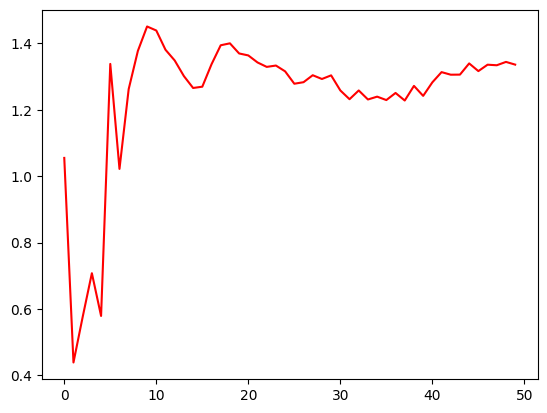

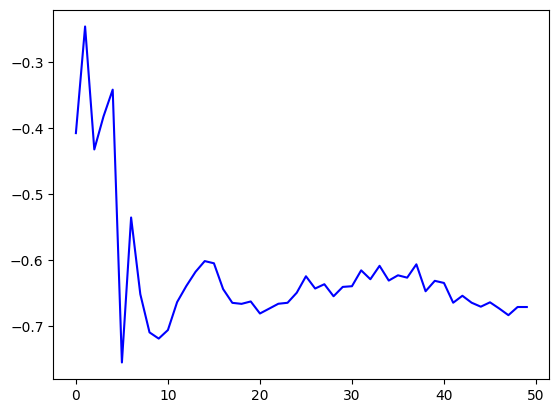

In [11]:
# Loss history
plt.plot(hist.history['D_loss'], c='red'); plt.show()
plt.plot(hist.history['G_loss'], c='blue'); plt.show()

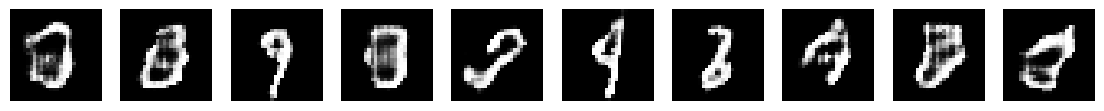

In [12]:
# Generate MNIST images
n_sample = 10
z = np.random.uniform(-1.0, 1.0, size=[n_sample, nG_input])
gen_img = G(z).numpy()

fig, ax = plt.subplots(1, n_sample, figsize=(14, 4))
for i in range(n_sample):
    p = gen_img[i, :, :]
    ax[i].imshow(p, cmap='gray')
    ax[i].axis('off')
plt.show()

comparaison 100 epochs dcgan vs unrolleddcgan